**Dependencies**

In [1]:
import random
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from time import time

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from nltk.translate.bleu_score import corpus_bleu

In [2]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/captions.txt.zip")
zip_ref.extractall()
zip_ref.close()

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
dataset_images_path = "/content/drive/MyDrive/Images/"

In [5]:
img_height = 180
img_width = 180
validation_split = 0.2

**Encoder Model-Inception V3**

In [6]:
def get_encoder():
  image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
  new_input = image_model.input
  hidden_layer = image_model.layers[-1].output

  image_features_extract_model = tf.keras.Model(new_input,hidden_layer)
  return image_features_extract_model

**Read Captions**

In [7]:
def get_preprocessed_caption(caption):
  caption = re.sub(r'\s+', ' ',caption)
  caption = caption.strip()
  caption = "<start> " + caption + " <end>"
  return caption

In [8]:
images_captions_dict = {}

with open('captions.txt','r') as dataset_info:

  next(dataset_info)

  for info_raw in list(dataset_info)[:4000]:
    info = info_raw.split(",")
    image_filename = info[0]
    caption = get_preprocessed_caption(info[1])

    if image_filename not in images_captions_dict.keys():
      images_captions_dict[image_filename] = [caption]
    else:
      images_captions_dict[image_filename].append(caption)

**Read images**

In [9]:
def load_image(image_path):
  img = tf.io.read_file(dataset_images_path + image_path)
  img = tf.image.decode_jpeg(img,channels=3)
  img = tf.image.resize(img,(img_height,img_width))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img,image_path

In [10]:
image_captions_dict_keys = list(images_captions_dict.keys())
image_dataset = tf.data.Dataset.from_tensor_slices(image_captions_dict_keys)
#for i in image_dataset:
  #print(i)
image_dataset = image_dataset.map(load_image,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [11]:
count = 0
for img_tensor,path_tensor in image_dataset:
  print(img_tensor[0])
  #print(len(img_tensor))
  #print(len(path_tensor))

tf.Tensor(
[[[-0.35573715 -0.2646333  -0.21158314]
  [-0.09564269  0.04847491  0.04934645]
  [-0.38660115 -0.2686273  -0.46249074]
  ...
  [-0.9643062  -0.97701496 -0.9683368 ]
  [-0.9814815  -0.97995645 -0.97657955]
  [-0.9444794  -0.90188706 -0.9437167 ]]

 [[-0.372658   -0.29542482 -0.23910677]
  [-0.08104575  0.05620921  0.10326803]
  [-0.28616548 -0.14727658 -0.3372547 ]
  ...
  [-0.9269061  -0.89531547 -0.9510893 ]
  [-0.9529412  -0.9281046  -0.9503268 ]
  [-0.8693919  -0.74390304 -0.97135144]]

 [[-0.39862025 -0.34473497 -0.23202616]
  [-0.03736383  0.11710238  0.10631812]
  [-0.20413935 -0.04045016 -0.24952781]
  ...
  [-0.95769787 -0.9155407  -0.9727668 ]
  [-0.9228758  -0.90392154 -0.9427015 ]
  [-0.92345726 -0.86797446 -0.94800305]]

 ...

 [[ 0.40402925 -0.2663427  -0.7943365 ]
  [ 0.08650553 -0.48365062 -0.7453102 ]
  [ 0.22987795 -0.06485993 -0.5486269 ]
  ...
  [ 0.5687294   0.70366275  0.5487586 ]
  [ 0.27908504  0.44782138  0.69651425]
  [ 0.26801002  0.44822085  0.594

In [12]:
images_dict = {}

encoder = get_encoder()

for img_tensor,path_tensor in tqdm(image_dataset):
  batch_features_tensor = encoder(img_tensor)
  print(batch_features_tensor[0].shape)
  for batch_features,path in zip(batch_features_tensor,path_tensor):
    decoded_path = path.numpy().decode("utf-8")
    images_dict[decoded_path] = batch_features.numpy()

  0%|          | 0/13 [00:00<?, ?it/s]

(4, 4, 2048)


 15%|█▌        | 2/13 [00:05<00:27,  2.54s/it]

(4, 4, 2048)


 23%|██▎       | 3/13 [00:06<00:16,  1.61s/it]

(4, 4, 2048)


 31%|███       | 4/13 [00:06<00:09,  1.09s/it]

(4, 4, 2048)


 38%|███▊      | 5/13 [00:07<00:07,  1.13it/s]

(4, 4, 2048)


 46%|████▌     | 6/13 [00:07<00:05,  1.35it/s]

(4, 4, 2048)


 54%|█████▍    | 7/13 [00:08<00:03,  1.54it/s]

(4, 4, 2048)


 62%|██████▏   | 8/13 [00:08<00:03,  1.66it/s]

(4, 4, 2048)


 69%|██████▉   | 9/13 [00:09<00:02,  1.76it/s]

(4, 4, 2048)


 77%|███████▋  | 10/13 [00:09<00:01,  1.88it/s]

(4, 4, 2048)


 85%|████████▍ | 11/13 [00:09<00:00,  2.08it/s]

(4, 4, 2048)


 92%|█████████▏| 12/13 [00:10<00:00,  2.40it/s]

(4, 4, 2048)


100%|██████████| 13/13 [00:11<00:00,  1.36it/s]

(4, 4, 2048)


100%|██████████| 13/13 [00:20<00:00,  1.58s/it]


In [13]:
print(images_dict['1000268201_693b08cb0e.jpg'].shape)

(4, 4, 2048)


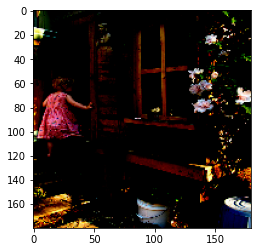

In [14]:
plt.imshow(load_image('1000268201_693b08cb0e.jpg')[0].numpy())

**Get images and labels from filenames**

In [15]:
def get_images_labels(image_filenames):
  images = []
  labels = []

  for image_filename in image_filenames:
    image = images_dict[image_filename]
    captions = images_captions_dict[image_filename]

    for caption in captions:
      images.append(image)
      labels.append(caption)
  return images,labels

In [16]:
image_filenames = list(images_captions_dict.keys())
image_filename_train,image_filename_test = train_test_split(image_filenames,test_size=validation_split,random_state=1)

X_train,y_train_raw = get_images_labels(image_filename_train)
X_test,y_test_raw = get_images_labels(image_filename_test)

In [17]:
len(X_train), len(y_train_raw), len(X_test), len(y_test_raw)

(3200, 3200, 800, 800)

In [18]:
top_k = 4000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

tokenizer.fit_on_texts(y_train_raw)



In [19]:
print(len(tokenizer.word_index))

2455


In [20]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

y_train = tokenizer.texts_to_sequences(y_train_raw)
print(y_train)
y_train = tf.keras.preprocessing.sequence.pad_sequences(y_train,padding='post')
print(y_train)

[[4, 2, 17, 10, 19, 9, 8, 39, 6, 21, 3], [4, 2, 17, 9, 8, 47, 7, 2, 998, 68, 18, 2, 166, 22, 146, 501, 670, 326, 3], [4, 2, 9, 8, 399, 247, 502, 72, 13, 5, 21, 3], [4, 2, 9, 8, 399, 21, 95, 13, 670, 3], [4, 2, 9, 501, 95, 21, 3], [4, 2, 38, 69, 7, 2, 111, 999, 3], [4, 2, 16, 6, 2, 287, 150, 3], [4, 2, 16, 50, 6, 111, 3], [4, 2, 65, 8, 50, 6, 5, 111, 3], [4, 5, 16, 25, 5, 75, 10, 19, 34, 10, 115, 8, 50, 6, 5, 111, 3], [4, 2, 38, 6, 2, 75, 185, 8, 63, 42, 2, 327, 13, 567, 6, 26, 1373, 400, 3], [4, 2, 16, 288, 45, 2, 163, 167, 3], [4, 2, 28, 16, 63, 45, 2, 163, 1000, 3], [4, 2, 28, 16, 63, 5, 567, 18, 57, 1000, 3], [4, 2, 28, 16, 6, 2, 75, 185, 288, 45, 2, 163, 1374, 3], [4, 2, 365, 65, 12, 54, 671, 401, 13, 672, 289, 7, 2, 248, 3], [4, 119, 23, 328, 24, 25, 54, 671, 1375, 13, 672, 1376, 3], [4, 119, 23, 33, 503, 1377, 13, 128, 92, 40, 6, 568, 673, 3], [4, 46, 20, 12, 401, 13, 672, 289, 10, 258, 2, 134, 3], [4, 14, 20, 25, 401, 13, 672, 289, 276, 88, 134, 1001, 6, 2, 504, 3], [4, 2, 16, 2

In [21]:
tokenizer.word_index

{'<unk>': 1,
 'a': 2,
 'end': 3,
 'start': 4,
 'the': 5,
 'in': 6,
 'on': 7,
 'is': 8,
 'dog': 9,
 'and': 10,
 'man': 11,
 'with': 12,
 'of': 13,
 'two': 14,
 'boy': 15,
 'girl': 16,
 'black': 17,
 'to': 18,
 'white': 19,
 'woman': 20,
 'water': 21,
 'at': 22,
 'young': 23,
 'are': 24,
 'wearing': 25,
 'an': 26,
 'his': 27,
 'little': 28,
 'brown': 29,
 'red': 30,
 'dogs': 31,
 'blue': 32,
 'people': 33,
 'shirt': 34,
 'through': 35,
 'down': 36,
 'running': 37,
 'child': 38,
 'playing': 39,
 'while': 40,
 'grass': 41,
 'up': 42,
 'sitting': 43,
 'small': 44,
 'into': 45,
 'three': 46,
 'standing': 47,
 'beach': 48,
 'front': 49,
 'jumping': 50,
 'rock': 51,
 'person': 52,
 'ball': 53,
 'green': 54,
 'walking': 55,
 'children': 56,
 'her': 57,
 'field': 58,
 'by': 59,
 'large': 60,
 'over': 61,
 'yellow': 62,
 'climbing': 63,
 'near': 64,
 'girls': 65,
 'from': 66,
 'holding': 67,
 'next': 68,
 'jumps': 69,
 'stands': 70,
 'mouth': 71,
 'out': 72,
 'toy': 73,
 'another': 74,
 'pink': 7

In [22]:
tokenizer.index_word

{1: '<unk>',
 2: 'a',
 3: 'end',
 4: 'start',
 5: 'the',
 6: 'in',
 7: 'on',
 8: 'is',
 9: 'dog',
 10: 'and',
 11: 'man',
 12: 'with',
 13: 'of',
 14: 'two',
 15: 'boy',
 16: 'girl',
 17: 'black',
 18: 'to',
 19: 'white',
 20: 'woman',
 21: 'water',
 22: 'at',
 23: 'young',
 24: 'are',
 25: 'wearing',
 26: 'an',
 27: 'his',
 28: 'little',
 29: 'brown',
 30: 'red',
 31: 'dogs',
 32: 'blue',
 33: 'people',
 34: 'shirt',
 35: 'through',
 36: 'down',
 37: 'running',
 38: 'child',
 39: 'playing',
 40: 'while',
 41: 'grass',
 42: 'up',
 43: 'sitting',
 44: 'small',
 45: 'into',
 46: 'three',
 47: 'standing',
 48: 'beach',
 49: 'front',
 50: 'jumping',
 51: 'rock',
 52: 'person',
 53: 'ball',
 54: 'green',
 55: 'walking',
 56: 'children',
 57: 'her',
 58: 'field',
 59: 'by',
 60: 'large',
 61: 'over',
 62: 'yellow',
 63: 'climbing',
 64: 'near',
 65: 'girls',
 66: 'from',
 67: 'holding',
 68: 'next',
 69: 'jumps',
 70: 'stands',
 71: 'mouth',
 72: 'out',
 73: 'toy',
 74: 'another',
 75: 'pink

In [23]:
max_caption_length = max(len(t) for t in y_train)
print(max_caption_length)

35


In [24]:
[tokenizer.index_word[i] for i in y_train[1]]

['start',
 'a',
 'black',
 'dog',
 'is',
 'standing',
 'on',
 'a',
 'step',
 'next',
 'to',
 'a',
 'river',
 'at',
 'it',
 'shakes',
 'itself',
 'dry',
 'end',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

**Generate Tensorflow dataset**

In [25]:
dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))

In [26]:
BUFFER_SIZE = len(X_train)
BATCH_SIZE = 64


dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [27]:
NUM_STEPS = BUFFER_SIZE // BATCH_SIZE

**Models Definition**

In [28]:
class CNN_Encoder(tf.keras.Model):
  def __init__(self,embedding_dim):
    super(CNN_Encoder,self).__init__()
    self.flat = tf.keras.layers.Flatten()
    self.fc = tf.keras.layers.Dense(embedding_dim)
  def call(self,x):
    x = self.flat(x)

    #print(x.shape)
    x = self.fc(x)
    #print(x.shape)
    return x

**RNN Decoder**

In [29]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self,embedding_dim,units,vocab_size):
    super(RNN_Decoder,self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)

    self.lstm = tf.keras.layers.LSTM(self.units,return_sequences=True,return_state=True)

    self.fc = tf.keras.layers.Dense(vocab_size)

  def call(self,captions,features,omit_features=False,initial_state=None,verbose=False):
    if verbose:
      print("Before embedding")
      print(captions.shape)

    embed = self.embedding(captions)

    if verbose:
      print("Embed")
      print(embed.shape)
      print(features.shape)
    
    features = tf.expand_dims(features,1)

    if verbose:
      print("Features")
      print(features.shape)
    
    lstm_input = tf.concat([features,embed],axis=-2) if (omit_features==False) else embed

    if verbose:
      print("LSTM input")
      print(lstm_input.shape)

    output,memory_state,carry_state = self.lstm(lstm_input,initial_state=initial_state)
    #print(output)
    if verbose:
      print("LSTM output")
      print(output.shape)

      
    output = self.fc(output)
    return output, memory_state, carry_state

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

**Train Stage**

In [30]:
units = embedding_dim = 512

vocab_size = min(top_k+1,len(tokenizer.word_index.keys()))

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim,units,vocab_size)

optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real,pred,verbose=False):

  loss_ = loss_object(real,pred)

  if verbose:
    print("Loss")
    print(loss_)
  
  loss_ = tf.reduce_mean(loss_,axis=1)

  if verbose:
    print("After mean axis 1")
    print(loss_)

  return loss_

In [31]:
def train_step(img_tensor,target,verbose=False):
  if True:
    print("Image tensor")
    print(img_tensor.shape)

    print("Target")
    print(target.shape)

  dec_input = tf.convert_to_tensor(target[:,:-1])

  with tf.GradientTape() as tape:
    features = encoder(img_tensor)
        
    if verbose:
        print("Features CNN")
        print(features)
        
    predictions, _, _ = decoder(dec_input, features, verbose=False)

    if verbose:
        print("Predictions RNN")
        print(predictions)
    
    caption_loss = loss_function(target, predictions)
    
    total_batch_loss = tf.reduce_sum(caption_loss) 
    mean_batch_loss = tf.reduce_mean(caption_loss)

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradient = tape.gradient(caption_loss,trainable_variables)
  optimizer.apply_gradients(zip(gradient,trainable_variables))

  return total_batch_loss, mean_batch_loss

In [32]:
#for img,cap in dataset:
  #print(cap[:,:-1])

 **Checkpoint**

In [33]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [34]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  
    ckpt.restore(ckpt_manager.latest_checkpoint)

 **Start training**

In [35]:
loss_plot = []

In [36]:
EPOCHS = 10
start_epoch = 0

for epoch in range(start_epoch, EPOCHS):
  real_epoch = len(loss_plot) + 1
  start = time()
  total_loss = 0

  for (batch, (img_tensor, target)) in enumerate(dataset):
    total_batch_loss, mean_batch_loss = train_step(img_tensor, target, verbose=False)
    total_loss += total_batch_loss

    if batch % 100 == 0:
      print ('Epoch {} Batch {} Batch Loss {:.4f}'.format(real_epoch, batch, mean_batch_loss.numpy()))

  print('Total Loss {:.6f}'.format(total_loss))
  epoch_loss = total_loss / NUM_STEPS
    
    
  loss_plot.append(epoch_loss)

  if epoch % 5 == 0:
      ckpt_manager.save()

  print ('Epoch {} Epoch Loss {:.6f}'.format(real_epoch, epoch_loss))
  print ('Time taken for 1 epoch {} sec\n'.format(time() - start))
  

Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Epoch 1 Batch 0 Batch Loss 1.2413
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)
Image tensor
(64, 4, 4, 2048)
Target
(64, 35)


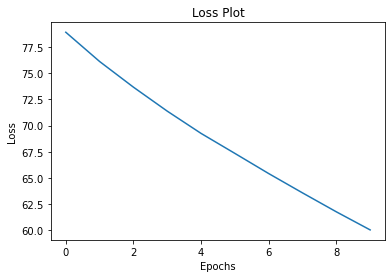

In [37]:

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [38]:
def clean_caption(caption):
  return [item for item in caption if item not in ['start','end','<pad>']]

In [39]:
test_img_name =random.choice(image_filename_train)

In [40]:
def get_caption(img):
  features = encoder(tf.expand_dims(img,0))

  caption = []
  #print(caption)
  dec_input = tf.expand_dims([],0)

  state = None
  for i in range(1,max_caption_length):
    predictions,memory_state,carry_state = decoder(dec_input,features,omit_features=i>1,initial_state=state)
    #print(memory_state)
    #print(predictions)
    word_index = np.argmax(predictions.numpy().flatten())
    #print(word_index)

    caption.append(tokenizer.index_word[word_index])
    #print(caption)
    dec_input = tf.expand_dims([word_index],0)
    state = [memory_state,carry_state]
  
  state = decoder.reset_state(BATCH_SIZE)
  #print(caption)
  return clean_caption(caption)



Real captions
<start> A boy on a green plastic swing . <end>
<start> A little boy sitting on a green swing . <end>
<start> A smiling boy plays on a green plastic swing-toy . <end>
<start> Boy swinging on a swing set . <end>
<start> Little boy riding on green swing in a playground . <end>
Esimated caption
['a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'sitting', 'on', 'a', 'bench']


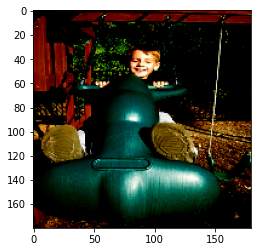

In [41]:
raw_img = load_image(test_img_name)[0]
img = images_dict[test_img_name]
captions = images_captions_dict[test_img_name]

plt.imshow(raw_img)

#print(raw_img.shape)
#print(tf.expand_dims(img,0))
print("Real captions")
for caption in captions:
    print(caption)

print("Esimated caption")
estimated_caption = get_caption(img)
print(estimated_caption)